In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Tue May 28 2024

@author: Yaning
"""

import os
import numpy as np
# from turtle import position
import torch
import pyro
from pyro.optim import Adam
from pyro.infer import SVI, Trace_ELBO
from tqdm import tqdm
import matplotlib.pyplot as plt
from statistics import mean
import itertools
import pyro.distributions as dist
# import no_sigma_es_no_meanu as agent
import pickle

/home/yaning/Documents/python_envs/spike/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


0.2512857142857143
0.474
0.8801428571428571
0.5594285714285714
0.5321428571428571
0.8591428571428571
0.22085714285714286
0.747
0.866
0.13085714285714287
0.8627142857142858
0.6742857142857143
0.6478571428571429
0.879
0.6592857142857143
0.8728571428571429
0.11642857142857142
0.3435714285714286
0.6347142857142857
0.2661428571428571
0.37314285714285716
0.424
0.5305714285714286
0.6817142857142857
0.12271428571428572
0.749
0.20742857142857143
0.6345714285714286
0.6472857142857142
0.6697142857142857
0.6441428571428571
0.638
0.47314285714285714
0.8054285714285714
0.47185714285714286
0.5587142857142857
0.793
0.381
0.5502857142857143
0.7364285714285714
0.8598571428571429
0.6405714285714286
0.12214285714285714
0.8325714285714285
0.8175714285714286
0.8684285714285714
0.2934285714285714
0.797
0.6081428571428571
0.6698571428571428
0.8811428571428571
0.8794285714285714
0.3975714285714286
0.16585714285714287
0.43614285714285717
0.21771428571428572
0.27171428571428574
0.8128571428571428
0.4144285714285

Mean ELBO 302054.91: 100%|████████████████████████████████████████████████████████████| 2000/2000 [00:39<00:00, 51.10it/s]


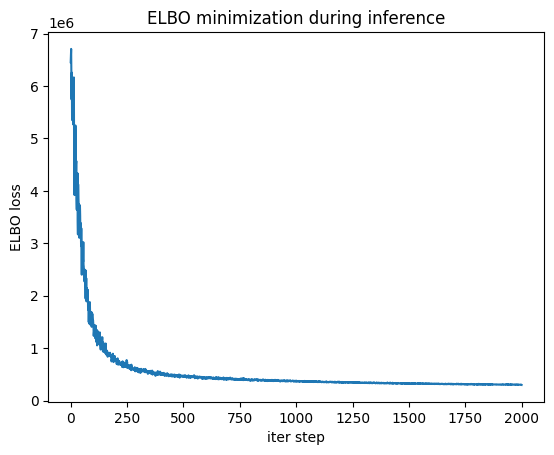

In [2]:
#-------------------------initialisation---------------------------------------
# initialise the param sample range (according to the already inferred results)
log_sigma_u_list = np.linspace(-2., 2., 1000)
log_a_list = np.linspace(-2., 2., 1000)
log_b_list = np.linspace(-2, 2., 1000)
log_beta_list = np.linspace(-2, 2, 1000)

param_list_list = [log_sigma_u_list, log_a_list, log_b_list, log_beta_list]

# initialise environment values
repetition = 10
real_delays = [  1.,   2.,   3.,   4.,   6.,   7.,  13.,  14.,  23.,  24.,  29.,
        32.,  45.,  50.,  58.,  62.,  73.,  75., 118., 122.]
delays =  [i / 10 for i in real_delays]
SS_values = [20.]

# LL values by percentage of SS
LL_values_p = [1.02  , 1.025 , 1.0255, 1.05  , 1.055 , 1.08  , 1.085 , 1.15  ,
       1.2   , 1.25  , 1.33  , 1.35  , 1.45  , 1.47  , 1.5   , 1.55  ,
       1.65  , 1.7   , 1.83  , 1.85  , 1.9   , 2.05  , 2.07  , 2.25  ,
       2.3   , 2.5   , 2.55  , 2.8   , 2.85  , 3.05  , 3.1   , 3.45  ,
       3.5   , 3.8   , 3.85  ]

LL_values = []
for i in LL_values_p:
    LL_values.append(i*20.)

environment_list = [repetition, delays, SS_values, LL_values]

# get all the combinations of the arrays
combinations = list(itertools.product(environment_list[1], environment_list[2], environment_list[3]))
# every combination appears ten times
multiplied_array = [x for x in combinations for _ in range(environment_list[0])]
multiplied_array = np.array(multiplied_array)
trial_num = multiplied_array.shape[0]
whole = multiplied_array


#-------------------------define functions-------------------------------------
def sample_param():
    log_sigma_u = np.random.choice(param_list_list[0])
    log_a = np.random.choice(param_list_list[1])
    log_b = np.random.choice(param_list_list[2])
    log_beta = np.random.choice(param_list_list[3])

    params = [log_sigma_u, log_a, log_b, log_beta]
    
    return params

# get the actions and add them to the data
def simulation(params):

    sigma_u = np.exp(params[0])
    sigma_u = np.repeat([sigma_u], trial_num)

    a = np.exp(params[1])
    a = np.repeat([a], trial_num)

    b = np.exp(params[2])
    b = np.repeat([b], trial_num)

    beta = np.repeat([np.exp(params[3])], trial_num)


    sigma_combine = sigma_u/(1+b*np.exp(-a*whole[:,0]))

    # major calculation 
    inferred_estimation = (whole[:,2])/(sigma_combine**2 + 1)






    # change everything to tensor
    # whole = torch.tensor(whole)
    inferred_estimation = torch.tensor(inferred_estimation)

    beta = torch.tensor(beta)
    # sum = inferred_estimation + torch.tensor(20.)

    # softmax_args = torch.stack([beta*inferred_estimation/sum, beta*torch.tensor(20.)/sum])
    softmax_args = torch.stack([beta*inferred_estimation, beta*torch.tensor(20.)])
    p = torch.softmax(softmax_args, dim = 0)[0]

    inferred_response_distr = dist.Bernoulli(probs=p)

    # get one possible predict actions
    inferred_response = inferred_response_distr.sample()

    return inferred_response

# if the percentage is lower than 0.1 or bigger than 0.9 then not using
# if the percentage fits the requirement then is good = 1
def check_percentage(params):
    good = 0
    inferred_response = simulation(params)
    choose_LL_percentage = len(list(filter(lambda x: (x == 1), inferred_response))
                            ) / len(inferred_response)
    if choose_LL_percentage > 0.10 and choose_LL_percentage < 0.90:
        good = 1
    return good, inferred_response, choose_LL_percentage


#--------------------------sampling--------------------------------------
sample_num = 200
agent_num = 200

# get an array of good parameters
good_params = []

while len(good_params) < sample_num:
    params = sample_param()
    if check_percentage(params)[0] == 1:
        good_params.append(params)
good_params = np.array(good_params)

# get the actions for each agent with the good_params
# each agent sample from the good_params array
data = []
param = []
for i in range(agent_num):
    one_agent_param = good_params[np.random.choice(good_params.shape[0])]
    param.append(one_agent_param)
    one_agent_data = []
    while len(one_agent_data) == 0:
        good, inferred_response, choose_percentage = check_percentage(one_agent_param)
        if good == 1:
            one_agent_data = np.hstack((whole, inferred_response.reshape(-1,1)))
        print(choose_percentage)
    data.append(one_agent_data)


data = np.array(data)
param = np.array(param)

def model(data):
    # sigma_es = (1-nova)a*e^(b*delay) + nova*c (as in constant)
    # in the order of 
    # 0:mean_u
    # 1:log_sigma_u
    # 2:log_a
    # 3:log_b
    # 4:log_beta
    num_params = 4
    num_agents = data.shape[0]
    num_trials = data.shape[1]
    # define hyper priors over model parameters
    # prior over sigma of a Gaussian is a Gamma distribution
    a = pyro.param('a', torch.ones(num_params, device='cuda'), constraint=dist.constraints.positive)
    lam = pyro.param('lam', torch.ones(num_params, device='cuda'), constraint=dist.constraints.positive)
    tau = pyro.sample('tau', dist.Gamma(a, a/lam).to_event(1)) # mean = a / (a/lam) = lam

    sig = pyro.deterministic('sig', 1/torch.sqrt(tau)) # Gauss sigma

    # each model parameter has a hyperprior defining group level mean
    # in the form of a Normal distribution
    m = pyro.param('m', torch.zeros(num_params)).to('cuda')
    s = pyro.param('s', torch.ones(num_params), constraint=dist.constraints.positive).to('cuda')
    mu = pyro.sample('mu', dist.Normal(m, s*sig).to_event(1)) # Gauss mu, wieso s*sig?

    # in order to implement groups, where each subject is independent of the others, pyro uses so-called plates.
    # you embed what should be done for each subject into the "with pyro.plate" context
    # the plate vectorizes subjects and adds an additional dimension onto all arrays/tensors
    # i.e. p1 below will have the length num_agents
    with pyro.plate('ag_idx', num_agents):
        # draw parameters from Normal and transform (for numeric trick reasons)
        base_dist = dist.Normal(torch.tensor(0., device='cuda'), torch.tensor(1., device='cuda')).expand_by([num_params]).to_event(1)
        # Transform via the pointwise affine mapping y = loc + scale*x (-> Neal's funnel)
        transform = dist.transforms.AffineTransform(mu, sig) 
        locs = pyro.sample('locs', dist.TransformedDistribution(base_dist, [transform]))

    group_indices = torch.arange(num_agents).unsqueeze(1).repeat(1, num_trials).reshape(-1)

    with pyro.plate('data', num_agents*num_trials):
        sigma_u = torch.exp(locs[:,0])[group_indices]
        a = torch.exp(locs[:,1])[group_indices]
        b = torch.exp(locs[:,2])[group_indices]
        beta = torch.exp(locs[:,3])[group_indices]

        sigma_combine = sigma_u/(1+b*torch.exp(-a*data[:,:,0].view(-1)))
        
        e_mean = (data[:,:,2].view(-1))/(1 + sigma_combine**2)

        # sum = e_mean + torch.tensor(20.)

        # softmax_args = torch.stack([beta*e_mean/sum, beta*torch.tensor(20.)/sum])
        softmax_args = torch.stack([beta*e_mean, beta*torch.tensor(20.)])
        p = torch.softmax(softmax_args, dim = 0)[0]
        pyro.sample("obs", dist.Bernoulli(probs = p), obs=data[:,:,3].view(-1))
    # return locs

def guide(data):
    num_params = 4
    num_agents = data.shape[0]
    # biject_to(constraint) looks up a bijective Transform from constraints.real 
    # to the given constraint. The returned transform is guaranteed to have 
    # .bijective = True and should implement .log_abs_det_jacobian().
    trns = torch.distributions.biject_to(dist.constraints.positive)

    # define mean vector and covariance matrix of multivariate normal
    m_hyp = pyro.param('m_hyp', torch.zeros(2*num_params)).to('cuda')
    st_hyp = pyro.param('scale_tril_hyp',
                    torch.eye(2*num_params),
                    constraint=dist.constraints.lower_cholesky).to('cuda')

    # set hyperprior to be multivariate normal
    # scale_tril (Tensor) – lower-triangular factor of covariance, with positive-valued diagonal
    hyp = pyro.sample('hyp',
                    dist.MultivariateNormal(m_hyp, scale_tril=st_hyp),
                    infer={'is_auxiliary': True})

    # mu & tau unconstrained
    unc_mu = hyp[..., :num_params]
    unc_tau = hyp[..., num_params:]

    # constrained tau, shape num_params, or num_particles, 1, num_params
    c_tau = trns(unc_tau)

    # ld = log_density
    # log_abs_det_jacobian(x, y) computes derivative |dy/dx|
    ld_tau = -trns.inv.log_abs_det_jacobian(c_tau, unc_tau)
    
    # sum_rightmost(x, dim)
    # sum out ``dim`` many rightmost dimensions of a given tensor.
    # ld_tau.shape is num_params, or num_particles, 1, num_params before sum_rightmost
    ld_tau = dist.util.sum_rightmost(ld_tau, ld_tau.dim() - c_tau.dim() + 1)

    # some numerics tricks
    mu = pyro.sample("mu", dist.Delta(unc_mu, event_dim=1))
    # c_tau shape: num_params, or num_particles, 1, num_params
    # ld_tau shape: [] or num_particles, 1,
    tau = pyro.sample("tau", dist.Delta(c_tau, log_density=ld_tau, event_dim=1))

    m_locs = pyro.param('m_locs', torch.zeros(num_agents, num_params)).to('cuda')
    st_locs = pyro.param('scale_tril_locs',
                    torch.eye(num_params).repeat(num_agents, 1, 1),
                    constraint=dist.constraints.lower_cholesky).to('cuda')
    
    with pyro.plate('ag_idx', num_agents):
        locs = pyro.sample("locs", dist.MultivariateNormal(m_locs, scale_tril=st_locs))

    return {'tau': tau, 'mu': mu, 'locs': locs, 'm_locs': m_locs, 'st_locs': st_locs}


#-------------------------------inference-----------------------------------
# doing inference

real_data = data
real_data = torch.tensor(real_data).to('cuda')

# print(real_data.shape)
# this is for running the notebook in our testing framework
smoke_test = ('CI' in os.environ)
# the step was 2000
n_steps = 2 if smoke_test else 2000

# assert pyro.__version__.startswith('1.8.6')

# clear the param store in case we're in a REPL
pyro.clear_param_store()# setup the optimizer
# the learning rate was 0.0005 , "betas": (0.90, 0.999)
# tried "n_par":15 in adam params but it does not have this argument
adam_params = {"lr": 0.01}
optimizer = Adam(adam_params)
# setup the inference algorithm
svi = SVI(model, guide, optimizer, loss=Trace_ELBO())
# svi = SVI(model_gamma, guide_gamma, optimizer, loss=Trace_ELBO())

loss = []
pbar = tqdm(range(n_steps), position = 0)
# do gradient steps
for step in pbar:
    loss.append(torch.tensor(svi.step(real_data)))
    pbar.set_description("Mean ELBO %6.2f" % torch.tensor(loss[-20:]).mean())
    # for name, value in pyro.get_param_store().items():
    #     print(name, pyro.param(name))
    if torch.isnan(loss[-1]):
        break

plt.figure()
plt.plot(loss)
plt.xlabel("iter step")
plt.ylabel("ELBO loss")
plt.title("ELBO minimization during inference")
plt.savefig('/home/yaning/Documents/Discounting/paper/results/parameter_recovery_four_param.png')



pos_dict = {}
for name, value in pyro.get_param_store().items():
    pos_dict[name] = value

# change the dictionary to numpy instead of tensor
# because somehow the tensor cannot be save with pickle
numpy_dict = {key: value.cpu().detach().numpy() for key, value in pos_dict.items()}

both_dict = {}
both_dict['real_param'] = param
both_dict['inferred_param'] = numpy_dict


with open('/home/yaning/Documents/Discounting/paper/results/parameter_recovery_four_param.pkl', 'wb') as f:
    pickle.dump(both_dict, f)

with open('/home/yaning/Documents/Discounting/paper/results/parameter_recovery_losses_four_param.pkl', 'wb') as f:
    pickle.dump(loss, f)